## Load data

In [1]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from pathlib import Path
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop('records', axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['rep', 'fps', 'highquality', 'route_index'])
    return df


def make_df(path: str):
    with open(path, "r") as f:

        p = Path(path)

        x = p.stem.split("_")
        data = {}
        data['fps'] = int(x[1])
        data['highquality'] = x[3]

        rep_no = [x[-1] for x in path.split('/') if 'rep' in x][0]
        data['rep'] = int(rep_no)
        content = json.load(f)
        data['records'] = content['_checkpoint']['records']

        df = pd.DataFrame(data)
        return process_df(df)

In [3]:
dfs = []
path = "data/ronin/rep*/*/*.json"
for file_path in glob.glob(path):
    # print(file_path)
    dfs.append(make_df(file_path))

In [4]:
df_combined = pd.concat(dfs).sort_index()
# filter out 16 fps
df_combined = df_combined.drop(16, level='fps', axis=0)

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10306 entries, (0, 12, 'True', 0) to (9, 20, 'True', 131)
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   route_id                           10306 non-null  object 
 1   status                             10306 non-null  object 
 2   infractions.collisions_layout      10306 non-null  object 
 3   infractions.collisions_pedestrian  10306 non-null  object 
 4   infractions.collisions_vehicle     10306 non-null  object 
 5   infractions.outside_route_lanes    10306 non-null  object 
 6   infractions.red_light              10306 non-null  object 
 7   infractions.route_dev              10306 non-null  object 
 8   infractions.route_timeout          10306 non-null  object 
 9   infractions.stop_infraction        10306 non-null  object 
 10  infractions.vehicle_blocked        10306 non-null  object 
 11  duration_game         

### Filter duplicated scenarios

In [5]:
# Routes of theese scenarios are duplicated
excluded_routes = [20, 21, 22, 23]
df_combined = df_combined.drop(excluded_routes, level='route_index', axis=0)


df_combined

route_id                    status infractions.collisions_layout infractions.collisions_pedestrian                     infractions.collisions_vehicle                    infractions.outside_route_lanes                              infractions.red_light infractions.route_dev infractions.route_timeout infractions.stop_infraction infractions.vehicle_blocked  duration_game  duration_system  route_length  score_composed  score_penalty  score_route  driving_score
rep fps highquality route_index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
0   12  True        0              RouteScenario_0                 Completed                            []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...  [Agent ran a red light 74444 at (x=186.95, y=1...                    []                        []                          []                          []     241.333341       591.438479    350.831252        5.156426       0.051564   100.000000       0.051564
                    1              RouteScenario_1                 Completed                            []                                []                                                 []                                                 []                                                 []                    []                        []                          []                          []     180.250005       429.191804    289.985251      100.000000       1.000000   100.000000       1.000000
                    2              RouteScenario_2                 Completed                            []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...                                                 []                    []                        []                          []                          []     159.500005       359.658650    272.631122       20.493741       0.204937   100.000000       0.204937
                    3              RouteScenario_3  Failed - Agent timed out                            []                                []  [Agent collided against object with type=vehic...                                                 []                                                 []                    []          [Route timeout.]                          []                          []     128.083337       287.444313    153.049630       26.970475       0.600000    44.950792       0.269705
                    4              RouteScenario_4  Failed - Agent timed out                            []                                []                                                 []  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     190.083339       470.218378    218.597426       51.477913       0.940798    54.717304       0.514779
...                                            ...                       ...                           ...                               ...                                                ...                                                ...                                                ...                   ...                       ...                         ...                         ...            ...              ...           ...             ...            ...          ...            ...
9   20  True      

## FPS factor, in high fidelity

In [6]:
df = df_combined.xs("True", level='highquality', drop_level=False)
df

route_id                    status infractions.collisions_layout infractions.collisions_pedestrian                     infractions.collisions_vehicle                    infractions.outside_route_lanes                              infractions.red_light infractions.route_dev infractions.route_timeout infractions.stop_infraction infractions.vehicle_blocked  duration_game  duration_system  route_length  score_composed  score_penalty  score_route  driving_score
rep fps highquality route_index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
0   12  True        0              RouteScenario_0                 Completed                            []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...  [Agent ran a red light 74444 at (x=186.95, y=1...                    []                        []                          []                          []     241.333341       591.438479    350.831252        5.156426       0.051564   100.000000       0.051564
                    1              RouteScenario_1                 Completed                            []                                []                                                 []                                                 []                                                 []                    []                        []                          []                          []     180.250005       429.191804    289.985251      100.000000       1.000000   100.000000       1.000000
                    2              RouteScenario_2                 Completed                            []                                []  [Agent collided against object with type=vehic...  [Agent went outside its route lanes for about ...                                                 []                    []                        []                          []                          []     159.500005       359.658650    272.631122       20.493741       0.204937   100.000000       0.204937
                    3              RouteScenario_3  Failed - Agent timed out                            []                                []  [Agent collided against object with type=vehic...                                                 []                                                 []                    []          [Route timeout.]                          []                          []     128.083337       287.444313    153.049630       26.970475       0.600000    44.950792       0.269705
                    4              RouteScenario_4  Failed - Agent timed out                            []                                []                                                 []  [Agent went outside its route lanes for about ...                                                 []                    []          [Route timeout.]                          []                          []     190.083339       470.218378    218.597426       51.477913       0.940798    54.717304       0.514779
...                                            ...                       ...                           ...                               ...                                                ...                                                ...                                                ...                   ...                       ...                         ...                         ...            ...              ...           ...             ...            ...          ...            ...
9   20  True      

In [7]:
# df = df.reset_index()
df.groupby('fps')["score_composed"].mean().sort_index(ascending=False)

fps
20    86.023896
18    86.105043
17    84.350222
15    80.233737
14    76.210005
12    59.088986
10    49.388818
Name: score_composed, dtype: float64

In [8]:
def plot(column: str, ax=None, col="b", marker='s'):
    axes = df.groupby('fps')[column].mean().sort_index(
        ascending=False).plot(linestyle='dashed', marker=marker, color=col,)

    return axes

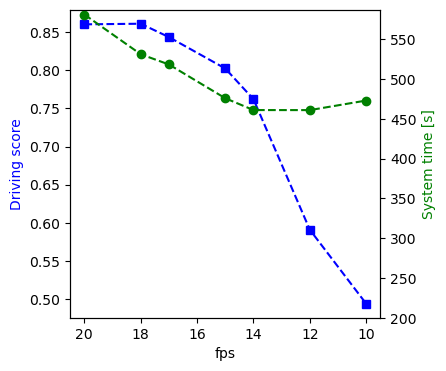

In [9]:
fig, axes = plt.subplots(squeeze=True)
fig.set_size_inches(4, 4)
axes = plot("driving_score", axes)
axes.set_ylabel(f"Driving score", color='b')

axes = plot("duration_system", axes.twinx(), 'g', marker='o')
axes.set_ylabel(f"System time [s]", color='g')
axes.set_ylim(200)
axes.invert_xaxis()
# fig

### Error bars

In [10]:
df.groupby(["rep"])["driving_score"].mean()

rep
0    0.789923
1    0.743769
2    0.745008
3    0.747457
4    0.745712
5    0.745058
6    0.748941
7    0.748155
8    0.790319
9    0.776669
Name: driving_score, dtype: float64

#### ^ Pretty consitent repetitions

In [11]:
# mean across all scenarios
agg = df.groupby(["fps", "rep"])["driving_score"].mean()
# agg

In [12]:
agg.groupby("fps").min()
agg.groupby("fps").max()
agg.groupby("fps").mean()

fps
10    0.493888
12    0.587316
14    0.762100
15    0.802337
17    0.853484
18    0.861050
20    0.860239
Name: driving_score, dtype: float64

In [13]:
def plot_better(df, ax, column, style, err=True):
    agg = df.groupby(["fps", "rep"])[column].mean()
    mean = agg.groupby("fps").mean()

    range = np.vstack([np.abs(agg.groupby("fps").min()-mean),
                       np.abs(agg.groupby("fps").max()-mean)])

    yerr = range if err else None

    ax.errorbar(
        mean.index,
        mean,
        yerr=yerr,
        **style)
    return ax

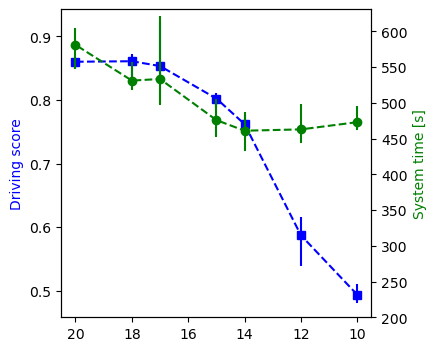

In [14]:
fig, ax = plt.subplots(squeeze=True)
fig.set_size_inches(4, 4)

style = dict(linestyle='dashed', marker='s', color='blue',)
ax = plot_better(df, ax, "driving_score", style)
ax.set_ylabel(f"Driving score", color='b')

style = dict(linestyle='dashed', marker='o', color='green',)
ax = plot_better(df, ax.twinx(), "duration_system", style)
ax.set_ylabel(f"System time [s]", color='g')

ax.set_ylim(200)
ax.invert_xaxis()

#### ^ Error bars for driving score more consistent than system time

Normalize system time

### Normalize system time

In [15]:
oracle = df.xs(20, level='fps', drop_level=False).sort_index()

# oracle

In [16]:
# average time to perform each scenario
df['norm_sys_time'] = df['duration_system'] / \
    oracle.groupby('route_index')["duration_system"].mean()

/tmp/ipykernel_15271/4008945638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_sys_time'] = df['duration_system'] / \


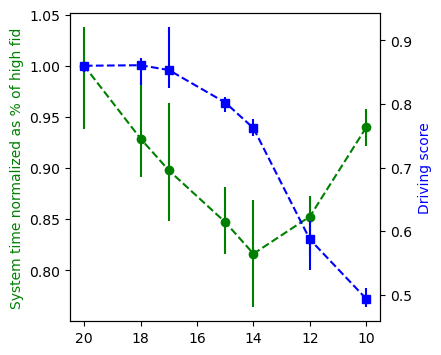

In [17]:
fig, ax = plt.subplots(squeeze=True)
fig.set_size_inches(4, 4)

style = dict(linestyle='dashed', marker='o', color='green',)
ax = plot_better(df, ax, "norm_sys_time", style)
ax.set_ylabel(f"System time normalized as % of high fid", color='g')

style = dict(linestyle='dashed', marker='s', color='blue',)
ax = plot_better(df, ax.twinx(), "driving_score", style)
ax.set_ylabel(f"Driving score", color='b')


ax.invert_xaxis()

### Prediction error

In [18]:
# oracle.groupby('route_index')['driving_score'].mean()

In [19]:


df['square_error'] = (df['driving_score'] -
                      oracle.groupby('route_index')['driving_score'].mean()).pow(2).pow(1./2)

/tmp/ipykernel_15271/7081481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['square_error'] = (df['driving_score'] -


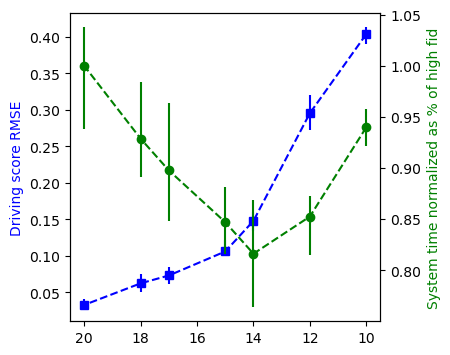

In [20]:
fig, ax = plt.subplots(squeeze=True)
fig.set_size_inches(4, 4)

style = dict(linestyle='dashed', marker='s', color='blue',)
ax = plot_better(df, ax, "square_error", style)
ax.set_ylabel(f"Driving score RMSE", color='b')


style = dict(linestyle='dashed', marker='o', color='green',)
ax = plot_better(df, ax.twinx(), "norm_sys_time", style,)
ax.set_ylabel(f"System time normalized as % of high fid", color='g')

ax.invert_xaxis()

### Box plots

In [21]:
agg = df.groupby(["fps", "rep"])['driving_score'].mean()
pos = agg.reset_index().groupby('fps')['driving_score'].mean().index

In [22]:
def do_boxplot(df, column, ax=None):
    agg = df.groupby(["fps", "rep"])[column].mean()
    # use index as possition for correct spacing
    pos = agg.reset_index().groupby('fps')[column].mean().index
    agg.reset_index().boxplot(by='fps', column=column, ax=ax,
                              grid=True, positions=pos, widths=0.8)

Text(0.5, 1.0, '')

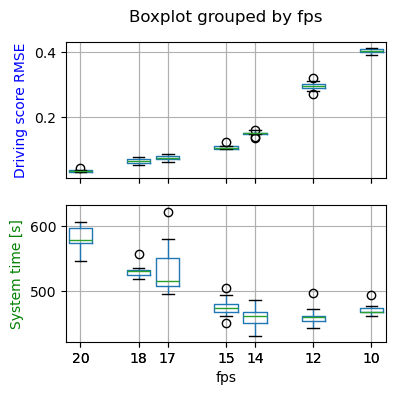

In [23]:
fig, ax = plt.subplots(nrows=2, squeeze=True, sharex=True)
fig.set_size_inches(4, 4)

do_boxplot(df, 'square_error', ax[0])

ax[0].set_ylabel(f"Driving score RMSE", color='b')
ax[0].set_title("")
ax[0].set_xlabel("")

ax[0].invert_xaxis()
do_boxplot(df, 'duration_system', ax[1])

ax[1].set_ylabel(f"System time [s]", color='g')
ax[1].set_title("")

## LOW/EPIC factor, in high fidelity

In [24]:
df10 = df_combined.xs(10, level='fps', axis=0, drop_level=False).sort_index()
df20 = df_combined.xs(20, level='fps', axis=0, drop_level=False).sort_index()

df1020 = pd.concat([df10, df20]).sort_index()
df1020

route_id                    status                      infractions.collisions_layout infractions.collisions_pedestrian                     infractions.collisions_vehicle infractions.outside_route_lanes infractions.red_light infractions.route_dev infractions.route_timeout infractions.stop_infraction infractions.vehicle_blocked  duration_game  duration_system  route_length  score_composed  score_penalty  score_route  driving_score
rep fps highquality route_index                                                                                                                                                                                                                                                                                                                                                                                                                                                            
0   20  True        0              RouteScenario_0                 Completed  [Agent collided against object with type=stati...                                []                                                 []                              []                    []                    []                        []                          []                          []     220.250003       848.721987    350.831252       65.000000           0.65   100.000000       0.650000
                    1              RouteScenario_1  Failed - Agent timed out                                                 []                                []                                                 []                              []                    []                    []          [Route timeout.]                          []                          []     251.050004       938.274112    289.985251       84.331496           1.00    84.331496       0.843315
                    2              RouteScenario_2                 Completed                                                 []                                []                                                 []                              []                    []                    []                        []                          []                          []     160.400002       575.346033    272.631122      100.000000           1.00   100.000000       1.000000
                    3              RouteScenario_3                 Completed                                                 []                                []                                                 []                              []                    []                    []                        []                          []                          []      97.550001       340.518655    153.049630      100.000000           1.00   100.000000       1.000000
                    4              RouteScenario_4                 Completed                                                 []                                []                                                 []                              []                    []                    []                        []                          []                          []     181.800003       707.752329    218.597426      100.000000           1.00   100.000000       1.000000
...                                            ...                       ...                                                ...                               ...                                                ...                             ...                   ...                   ...                       ...                         ...                         ...            ...              ...           ...             ...            ...          ...            ...
9   20  True        127          RouteScenario_127                 Completed                                                 []                                []                                                 []                      

In [25]:


low_20 = df20.xs('False', axis=0, level='highquality')
epic_20 = df20.xs('True', axis=0, level='highquality')
# low_20
low_20

route_id                    status infractions.collisions_layout infractions.collisions_pedestrian                     infractions.collisions_vehicle                    infractions.outside_route_lanes infractions.red_light infractions.route_dev infractions.route_timeout infractions.stop_infraction infractions.vehicle_blocked  duration_game  duration_system  route_length  score_composed  score_penalty  score_route  driving_score
rep fps route_index                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1   20  0              RouteScenario_0                 Completed                            []                                []                                                 []  [Agent went outside its route lanes for about ...                    []                    []                        []                          []                          []     214.650003       658.604211    350.831252       98.098078       0.980981   100.000000       0.980981
        1              RouteScenario_1  Failed - Agent timed out                            []                                []                                                 []                                                 []                    []                    []          [Route timeout.]                          []                          []     251.050004       770.301058    289.985251       50.043754       1.000000    50.043754       0.500438
        2              RouteScenario_2                 Completed                            []                                []  [Agent collided against object with type=vehic...                                                 []                    []                    []                        []                          []                          []     165.000002       507.712214    272.631122       60.000000       0.600000   100.000000       0.600000
        3              RouteScenario_3                 Completed                            []                                []                                                 []                                                 []                    []                    []                        []                          []                          []      97.550001       299.391218    153.049630      100.000000       1.000000   100.000000       1.000000
        4              RouteScenario_4  Failed - Agent timed out                            []                                []                                                 []                                                 []                    []                    []          [Route timeout.]                          []                          []     190.050003       588.518081    218.597426       81.414903       1.000000    81.414903       0.814149
...                                ...                       ...                           ...                               ...                                                ...                                                ...                   ...                   ...                       ...                         ...                         ...            ...              ...           ...             ...            ...          ...            ...
7   20  127          RouteScenario_127                 Completed                            []                                []                                                 []                                                 []                    []                    []                        []                          []      

In [26]:
low20_list = low_20.groupby('route_index')['driving_score'].apply(list)
epic20_list = epic_20.groupby('route_index')['driving_score'].apply(list)

array([[<Axes: title={'center': '0'}>]], dtype=object)

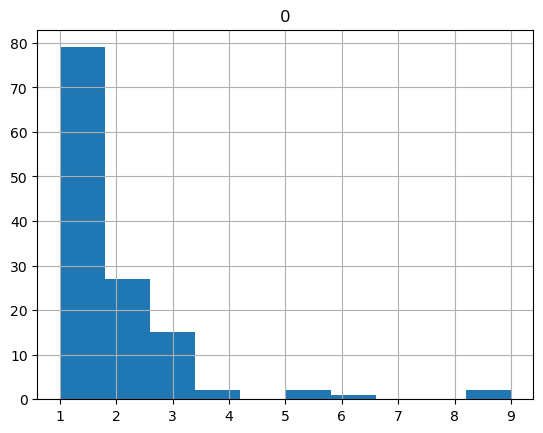

In [27]:
epic20_behaviours = {i: len(set(lst)) for i, lst in enumerate(epic20_list)}
low20_behaviours = {i: len(set(lst)) for i, lst in enumerate(low20_list)}

pd.DataFrame(epic20_behaviours.values(), index=epic20_behaviours.keys()).hist()

array([[<Axes: title={'center': '0'}>]], dtype=object)

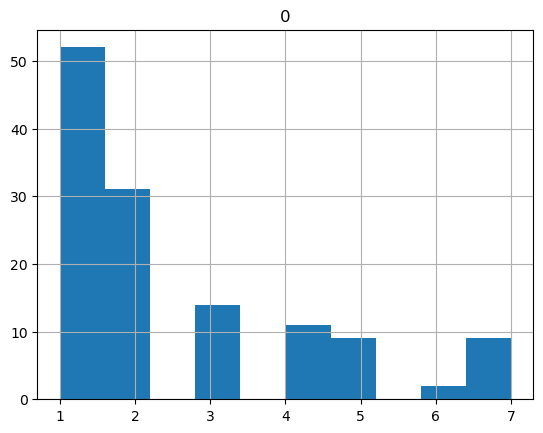

In [28]:
pd.DataFrame(low20_behaviours.values(), index=low20_behaviours.keys()).hist()

In [29]:
from scipy.stats import mannwhitneyu

diff = []
no_diff = []
for i, (epic, low) in enumerate(zip(epic20_list, low20_list)):
    U1, p = mannwhitneyu(epic, low, method="exact")

    confidence_level = 0.99
    max_error = 1 - confidence_level

    if p < max_error:
        print(
            f"\tThe difference for scenario: {i} is statistically significant. {p:.5f}")
        diff.append(i)
    else:
        print(
            f"\tThe difference for scenario: {i} is not statistically significant. {p:.5f}")
        no_diff.append(i)

	The difference for scenario: 0 is not statistically significant. 0.31479
	The difference for scenario: 1 is not statistically significant. 0.53620
	The difference for scenario: 2 is not statistically significant. 0.01851
	The difference for scenario: 3 is not statistically significant. 1.00000
	The difference for scenario: 4 is statistically significant. 0.00010
	The difference for scenario: 5 is statistically significant. 0.00010
	The difference for scenario: 6 is not statistically significant. 0.66907
	The difference for scenario: 7 is not statistically significant. 0.04309
	The difference for scenario: 8 is not statistically significant. 0.66907
	The difference for scenario: 9 is not statistically significant. 0.66907
	The difference for scenario: 10 is not statistically significant. 0.01851
	The difference for scenario: 11 is not statistically significant. 1.00000
	The difference for scenario: 12 is statistically significant. 0.00679
	The difference for scenario: 13 is not statist

In [30]:
print(
    f"For 128 scenarios there was a diffrence in {len(diff)} out of {128} which is {len(diff)/128} %")
print(diff)
print(no_diff)

For 128 scenarios there was a diffrence in 22 out of 128 which is 0.171875 %
[4, 5, 12, 18, 25, 40, 42, 46, 49, 75, 79, 80, 81, 83, 93, 102, 105, 107, 111, 117, 122, 126]
[0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 45, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 106, 108, 109, 110, 112, 113, 114, 115, 116, 118, 119, 120, 121, 123, 124, 125, 127]
